# Next run:
need to rerun the train_num modifications. bug in calculating the Z\*\*2 values. 

In [1]:
%run preamble.ipynb


## The preamble handles a few imports.
## It also loads common functions and dicts: 

## Bosch challenge specific:
* **getMCC**(tp,tn,fp,fn)

## ML/Analytics functions:
* **compare_train_test**(clf, ds_train, label_train, ds_test, label_test, mva='MVA', bins=50, use_vote=None, log=False)
* **plot_classifier_output**( pred_train, pred_test, y_train, y_test, multipagepdf=None, bins = None, normalised = True )
* **plot_correlations**(data,label='', \*\*kwds)
* **optimisePars**(mva, points, data , classes, fraction=0.7, score = 'log_loss', cvs=5)

---

## Various
* **showUniques**(df)
* **ensure_dir**(directory)
* **printBumper**(text, c='=', n=-1)
* **intersec**(d1, d2)
* **union**(d1, d2)

---

## Color dictionaries:
* **Tableau10**
* **Tableau10_Light**
* **Tableau10_Medium**
* **Tableau_20**
* **ColorBlind10**


In [5]:
%ls files

 Volume in drive C has no label.
 Volume Serial Number is 9C71-F73D

 Directory of C:\Users\maxxo_000\cygwin\Kaggle\Bosch\files

02.09.2016  22:48    <DIR>          .
02.09.2016  22:48    <DIR>          ..
02.09.2016  22:48        11.281.556 sample_submission.csv
02.09.2016  22:47     2.137.286.201 test_numeric.csv
02.09.2016  22:48     2.139.901.506 train_numeric.csv
               3 File(s)  4.288.469.263 bytes
               2 Dir(s)  48.317.190.144 bytes free


In [14]:
train_num = pd.read_csv("files/train_numeric.csv", usecols=["L0_S0_F0","Response"])

In [16]:
train_num.head(5)

,L0_S0_F0,Response
0,0.030,0
1,NaN,0
2,0.088,0
3,-0.036,0
4,-0.055,0


In [28]:
new = train_num.dropna()

In [29]:
gb = new.groupby("Response")

In [9]:
%matplotlib inline

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


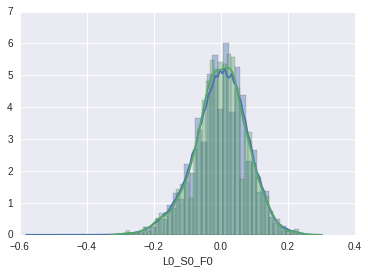

In [31]:
for g in gb.groups:
    sns.distplot(gb.get_group(g)["L0_S0_F0"], hist = True, label = "%i".format(g))

# Strategy:
* Build a multidimensional p-value from measurements and see how it is distributed (?)
* Find confidence interval, or cut on p-value that reduces dataset significantly (minimizing most important confusion matrix entry loss (fnr?))
* Predict remaining dataset with MVA classifier.

In [2]:
# first step is to get the mean and std values for each feature...
train_num = pd.read_csv("files/train_numeric.csv")

In [38]:
print(train_num.shape)
train_num.head(2)

(1183747, 970)


,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.03,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [73]:
train_num.Response.value_counts().apply(lambda x: 1e2*x/len(train_num))

0    99.418879
1     0.581121
Name: Response, dtype: float64

#### So there are only 0.58 % of pieces failing the quality control
Interestingly, when evaluating the perfect prediction on Kaggle, it is scored MCC=0.

In [39]:
train_num.describe()

C:\Users\maxxo_000\Anaconda3\envs\jupnote\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
count,1.183747e+06,673862.000000,673862.000000,673862.00000,673862.000000,673862.000000,673862.000000,673862.000000,673862.000000,6.738620e+05,...,3.035900e+04,30359.000000,30359.000000,30359.000000,30359.000000,59853.000000,59853.000000,59853.000000,59853.000000,1.183747e+06
mean,1.184050e+06,0.000055,0.000091,0.00004,0.000014,-0.000126,0.000161,-0.000044,-0.000359,6.722445e-07,...,8.564182e-07,0.000011,0.000413,0.000212,-0.002413,-0.000002,0.000037,0.000216,0.000056,5.811208e-03
std,6.834348e+05,0.080214,0.092799,0.21152,0.211635,0.094555,0.164469,0.019451,0.104133,1.148292e-01,...,4.327027e-04,0.000431,0.015370,0.007610,0.250091,0.000716,0.005785,0.008295,0.004196,7.600949e-02
min,4.000000e+00,-0.565000,-0.616000,-0.41500,-0.416000,-0.447000,-0.612000,-0.052000,-0.272000,-5.000000e-01,...,-2.000000e-03,0.000000,0.000000,0.000000,-0.750000,-0.001000,0.000000,0.000000,0.000000,0.000000e+00
25%,5.921385e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,1.184628e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
75%,1.775674e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
max,2.367495e+06,0.278000,0.302000,0.58500,0.584000,0.466000,0.388000,0.948000,0.688000,5.000000e-01,...,6.900000e-02,0.045000,1.000000,1.000000,0.250000,0.173000,1.000000,1.000000,1.000000,1.000000e+00


In [3]:
# use describe to calculate mean and std for each columns
s=time.time()
df = train_num[train_num.Response==0].drop(["Id","Response"],axis=1).describe()
print(time.time()-s)

C:\Users\maxxo_000\Anaconda3\envs\jupnote\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


357.4984440803528


In [18]:
cols = train_num.drop(["Response","Id"],axis=1).columns

In [37]:
from time import time as tt

In [122]:
# using describe is much faster (however needs way more memory)

'''slices=[[0,300],[300,600],[600,900],[900,len(cols)]]

for i,sl in enumerate(slices):
    s = tt()
    t = pd.read_csv("files/train_numeric.csv"
                    , usecols=cols[sl[0]:sl[1]].tolist()+["Response"])
    t = t[t.Response==0]
    r = tt()
    print("reading: ", r-s, " seconds")
    if i==0:
       std = pd.DataFrame(t.std())
       mean = pd.DataFrame(t.mean())
    else:
        std = pd.concat([std,pd.DataFrame(t.std())])
        mean = pd.concat([mean,pd.DataFrame(t.mean())])
    print("calc: ", tt()-r, " seconds")
    print("overall: ", tt()-s, " seconds for slice ", i+1,"/",len(slices))
'''    

reading:  86.87468576431274  seconds
calc:  73.76413941383362  seconds
overall:  160.65445041656494  seconds for slice  1 / 4
reading:  86.17608165740967  seconds
calc:  57.93268084526062  seconds
overall:  144.1087625026703  seconds for slice  2 / 4
reading:  116.40056347846985  seconds
calc:  85.42202687263489  seconds
overall:  201.83821606636047  seconds for slice  3 / 4
reading:  44.424741983413696  seconds
calc:  6.867697477340698  seconds
overall:  51.292439460754395  seconds for slice  4 / 4


* 2 columns take 34s
* 4 cols take 35.2s (vs 0.16 s calc)
* 10 cols take 35.8s (vs 0.35 s calc)

In [6]:
#gaus_pars = pd.concat([mean,std], axis=1)
#gaus_pars.columns = ["mean","std"]
#gaus_pars["LSF_tag"] = gaus_pars.index.values
#gaus_pars.index = range(len(gaus_pars))
#gaus_pars = gaus_pars[["LSF_tag","mean","std"]]
#gaus_pars.head(2)
gaus_pars = df.drop(["count","min","25%","50%","75%","max"],axis=0)

In [7]:
gaus_pars.to_csv("files/lsf_mean_std.csv")

## Calculate multidimensional p value

Here we need to calculate the p value per row.

In [ ]:
gaus_pars = pd.read_csv("files/lsf_mean_std.csv",index_col=0)

In [12]:
t = train_num[0:500]

In [18]:
import scipy.stats as st

In [145]:
# calculate Z_i**2 values 
for col in train_num.drop(["Id","Response"],axis=1).columns.values:
    train_num.loc[:,col] = pow(((train_num.loc[:,col]-gaus_pars.loc["mean",col])/(gaus_pars.loc["std",col])),2)

C:\Users\maxxo_000\Anaconda3\envs\jupnote\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


KeyError: 'the label [chi2] is not in the [index]'

In [109]:
train_num["chi2"] = train_num.drop(["Id","Response"],axis=1).sum(axis=1)

In [110]:
train_num["dof"] = (~train_num.drop(["Id","Response"],axis=1).apply(np.isnan,axis=1)).sum(axis=1)

In [131]:
train_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response,chi2,dof
0,4,0.139296,0.134866,0.868799,0.716440,1.561445,0.495831,0.591442,0.092540,0.030206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,148.815681,163
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,115.630321,193
2,7,1.201570,0.856914,0.000174,0.060757,2.904892,0.022762,0.591442,0.473640,3.840542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,115.527825,191
3,9,0.201988,0.476755,1.928235,2.427524,0.614977,0.956003,1.282895,1.517432,0.051430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,97.348868,191
4,11,0.470947,0.860281,1.928235,2.427524,1.561445,0.022762,2.383407,2.610978,2.166979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,120.470046,191


In [132]:
train_num[234:239]

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response,chi2,dof
234,464,0.598313,1.758724,0.000174,0.000178,5.910247,0.180176,0.597325,1.517432,0.281789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,145.113572,191
235,466,0.001452,1.182251,0.005166,0.009674,0.108510,0.022762,0.000004,0.473640,0.098051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,141.313322,205
236,469,0.001452,1.182251,0.005166,0.009674,0.108510,0.022762,0.000004,0.473640,0.098051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,141.313322,205
237,470,0.596116,0.266531,0.000174,0.005841,0.018486,0.956003,0.591442,0.092540,0.007647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,146.575772,191
238,471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,116.983710,193


In [111]:
stats = train_num.drop(train_num.columns[1:-3],axis=1)

In [112]:
stats["pval"] = [st.distributions.chi2.sf(x,y) for x,y in zip(stats.chi2,stats.dof)]

In [113]:
stats.head(2)

,Id,Response,chi2,dof,pval
0,4,0,148.815681,163,0.780063
1,6,0,115.630321,193,0.999998


## Prediction of failing chi2 calculation:
If chi2 cannot be calculated because all features are `NaN`.
* We clearly cannot decide based on numerical data.
* We need to consider this data in the next step.
* Lets keep the ids of these observations.
* We shouldn't just asign a prediction, as the rate of occurrence is about as high as the inital imbalance (2:580)

In [121]:
stats[stats.pval.isnull()][["Id","Response"]].to_csv("files/train_nan_pvals.csv")


In [122]:
stats = stats.dropna()

In [123]:
stats[stats.pval.isnull()]

,Id,Response,chi2,dof,pval


In [124]:
gb=stats.groupby("Response", sort=False)

In [129]:
stats[stats.Response==1].pval.describe()

count    6877.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: pval, dtype: float64

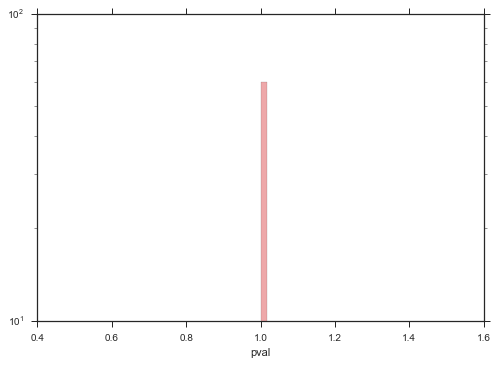

In [127]:
#sns.distplot(gb.get_group(0).pval,kde=None, bins=60, norm_hist=True,
#            color=Tableau_20['grey_light'],hist_kws={"log":True});
sns.distplot(gb.get_group(1).pval,kde=None, bins=60, norm_hist=True,
            color=Tableau_20['red'],hist_kws={"log":True});